In [1]:
pip install tsai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.2/324.2 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 18.5 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.10.1
    Uninstalling imbalanced-learn-0.10.1:
      Successfully uninstalled imbalanced-learn-0.10.1


In [2]:
import os
import shutil
from scipy import io #for loadmat, matlab conversion
import numpy as np
import matplotlib.pyplot as plt # for plotting training curves

import urllib.request # to get files from web w/o !wget

import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support

In [3]:
from tsai.basics import *
from tsai.inference import load_learner

In [4]:
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

def get_shapes(np_arr_list):
    """Returns text, each line is shape and dtype for numpy array in list
       example: print(get_shapes([X_train, X_test, y_train, y_test]))"""
    shapes = ""
    for i in np_arr_list:
        my_name = namestr(i,globals())
        shapes += (my_name[0] + " shape is " + str(i.shape) \
            + " data type is " + str(i.dtype) + "\n")
    return shapes

In [5]:
def get_py_file(fname, url):
    """checks for local file, if none downloads from URL.
    :return: nothing"""
    if (os.path.exists(fname)):
        print ("Local",fname, "found, skipping download")
    else:
        print("Downloading",fname, "from IMICS git repo")
        urllib.request.urlretrieve(url, filename=fname)

get_py_file(fname = 'load_data_utils.py', url = 'https://raw.githubusercontent.com/imics-lab/load_data_time_series/main/load_data_utils.py')


In [6]:
import load_data_utils as utils # ldu just seemed confusing!
print('My env_info: \n' + utils.get_env_info()) # using + vs , gets rid of space

My env_info: 
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
GPU: 


In [7]:
# Copy selected .py file into colab and import load_dataset function
# k_size is the size of the kernel used in the model, one-half of a second
# works well, actual value is based on sample freq e.g. 32Hz -> k_size = 16.
# EPOCHS are max run, training also has early stopping callback
def get_dataset(dataset):
    if (dataset == 'MobiAct HAR'):
        if (os.path.exists('MobiAct_Dataset_v1.0.zip')):
            print ("Local MobiAct zip found, skipping download")
        else:
            !gdown "1kt9wtIt7N7SIFQAbav7zcZ_PqTa5HegA&confirm=t" # MobiAct alternate file source
        # original share is https://drive.google.com/uc?id=0B5VcW5yHhWhibWxGRTZDd0dGY2s'
        # please see https://bmi.hmu.gr/the-mobifall-and-mobiact-datasets-2/ if not working
        get_py_file(fname = 'mobiact_adl_load_dataset.py',
                url = 'https://raw.githubusercontent.com/imics-lab/load_data_time_series/main/HAR/MobiAct/mobiact_adl_load_dataset.py')
        from mobiact_adl_load_dataset import mobiact_adl_load_dataset
        x_train, y_train, x_valid, y_valid, x_test, y_test = mobiact_adl_load_dataset(incl_val_group = True)
        k_size = 50
        EPOCHS = 50
        t_names = ['JOG','JUM','STD','STN','STU','WAL']
    elif (dataset == 'UniMiB SHAR'):
        get_py_file(fname = 'unimib_adl_load_dataset.py',
                url = 'https://raw.githubusercontent.com/imics-lab/load_data_time_series/main/HAR/UniMiB_SHAR/unimib_shar_adl_load_dataset.py')
        from unimib_adl_load_dataset import unimib_load_dataset
        x_train, y_train, x_valid, y_valid, x_test, y_test = unimib_load_dataset(incl_val_group = True)
        t_names = ['StandingUpFS','StandingUpFL','Walking','Running','GoingUpS','Jumping','GoingDownS','LyingDownFS','SittingDown']
        k_size = 50
        EPOCHS = 60
    elif (dataset == 'UCI HAR'):
        get_py_file(fname = 'uci_har_load_dataset.py',
                    url = 'https://raw.githubusercontent.com/imics-lab/load_data_time_series/main/HAR/UCI_HAR/uci_har_load_dataset.py')
        from uci_har_load_dataset import uci_har_load_dataset
        x_train, y_train, x_valid, y_valid, x_test, y_test = uci_har_load_dataset(incl_val_group = True, incl_xyz_accel= True)
        t_names = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS','SITTING','STANDING','LAYING']
        k_size = 50
        EPOCHS = 120
    elif (dataset == 'TWristAR'):
        # Note TWristAR is more updated than the previous datasets so the accesses
        # and defaults are a bit different, e.g. t_names is pulled from the .py
        get_py_file(fname = 'twristar_load_dataset.py',
                    url = 'https://raw.githubusercontent.com/imics-lab/load_data_time_series/main/HAR/TWristAR/twristar_load_dataset.py')
        import twristar_load_dataset as twristar_load_dataset # diff to get label map
        x_train, y_train, x_valid, y_valid, x_test, y_test \
                                = twristar_load_dataset.twristar_load_dataset(
                                    incl_val_group = True,
                                    one_hot_encode = True)
        t_names = list(twristar_load_dataset.label_map_twristar.get('label').keys())
        t_names.remove('Undefined')
        k_size = 16
        EPOCHS = 100
    elif (dataset == 'Leotta_2021'):
        get_py_file(fname = 'leotta_2021_load_dataset.py',
                    url = 'https://raw.githubusercontent.com/imics-lab/load_data_time_series/main/ADL/Leotta_2021/leotta_2021_load_dataset.py')
        #full_filename = my_path+os.path.join('/ADL/Leotta_2021/'+'leotta_2021_load_dataset.py')
        #shutil.copy(full_filename,'leotta_2021_load_dataset.py')
        import leotta_2021_load_dataset as leotta_2021_load_dataset
        x_train, y_train, x_valid, y_valid, x_test, y_test = leotta_2021_load_dataset.leotta_2021_load_dataset(incl_val_group = True, one_hot_encode = True)
        t_names = list(leotta_2021_load_dataset.label_map_leotta.get('label').keys())
        k_size = 100
        EPOCHS = 50
    elif (dataset == 'SHL'):
        # SHL takes about 30 minutes to process due to size, using saved arrays for now
        !gdown "1ApHVQ-P2reO6ctNVxeHHxCHeoNlp6c9P&confirm=t" # SHL 20Hz
        utils.unzip_into_dir('SHL_20hz_for_gentry.zip','SHL')
        input_dir = './SHL'
        x_train = np.load(input_dir + '/'+'x_train.npy')
        x_train = np.delete(x_train, [0,1,2], 2) # delete component accel
        x_test = np.load(input_dir + '/'+'x_test.npy')
        x_test = np.delete(x_test, [0,1,2], 2) # delete component accel
        y_train = np.load(input_dir + '/'+'y_train.npy')
        y_test = np.load(input_dir + '/'+'y_test.npy')
        # also don't have validate working in SHL so just using stratify
        x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.10, random_state=42, stratify=y_train)

        t_names = ['Still', 'Walking', 'Run', 'Bike', 'Car', 'Bus', 'Train', 'Subway']
        k_size = 15
        EPOCHS = 100
    elif (dataset == 'Gesture Phase Segmentation'):
        get_py_file(fname = 'gesture_phase_segmentation_load_dataset.py',
                    url = 'https://raw.githubusercontent.com/imics-lab/load_data_time_series/main/Gesturing_Signing/gesture_phase_segmentation_load_dataset.py')
        from gesture_phase_segmentation_load_dataset import gesture_phase_segmentation_load_dataset
        x_train, y_train, x_valid, y_valid, x_test, y_test, log_info \
                                = gesture_phase_segmentation_load_dataset(
                                    incl_val_group = True,
                                    return_info_dict = True)
        print("Note: Due to the size of the Gesture Phase Segmentation and for",
            "\ncompatibility, the test arrays are copies of the valid arrays")
        x_test = x_valid.copy()
        y_test = y_valid.copy()
        t_names = ["Rest", "Preparation", "Stroke","Hold", "Retraction"]
        k_size = 9
        EPOCHS = 100
    else:
        print('ERROR: dataset unknown')
    print(utils.tabulate_numpy_arrays({'x_train':x_train,'y_train':y_train,
                                    'x_valid':x_valid,'y_valid':y_valid,
                                    'x_test':x_test,'y_test':y_test}))
    return x_train, y_train, x_valid, y_valid, x_test, y_test, k_size, EPOCHS, t_names


In [8]:
ds_list = ["UniMiB SHAR",
           "UCI HAR",
           "TWristAR",
           "Leotta_2021",
           "Gesture Phase Segmentation"
           ]


In [9]:
def train_model(x_train, y_train, x_valid, y_valid):
  tfms = [None, TSClassification()]
  batch_tfms = TSStandardize(by_sample=True)
  mv_clf = TSClassifier(x_train, y_train, path='models', arch="InceptionTimePlus", tfms=tfms, batch_tfms=batch_tfms, metrics=accuracy, cbs=ShowGraph())
  mv_clf.fit_one_cycle(10, 1e-2)
  mv_clf.export("mv_clf.pkl")

In [10]:
def run_model(x_test):
  mv_clf = load_learner("models/mv_clf.pkl")
  probas, target, preds = mv_clf.get_X_preds(x_valid, y_valid)
  preds_labels = np.argmax(preds, axis=1)
  target_labels = np.argmax(target, axis=-1) # undo one-hot encoding
  return preds_labels, target_labels

**** Processing  UniMiB SHAR  ****
Raw data     shape        object type              data type
-----------  -----------  -----------------------  -----------
adl_data:    (7579, 453)  <class 'numpy.ndarray'>  float64
adl_labels:  (7579, 3)    <class 'numpy.ndarray'>  uint8
adl_names:   (9, 1)       <class 'numpy.ndarray'>  object
Reshaped data    shape           object type              data type
---------------  --------------  -----------------------  -----------
adl_data:        (7579, 151, 1)  <class 'numpy.ndarray'>  float64
adl_labels:      (7579, 3)       <class 'numpy.ndarray'>  uint8
adl_names:       (9, 1)          <class 'numpy.ndarray'>  object
x/y_train shape  (4601, 151, 1) (4601,)
x/y_validation shape  (1454, 151, 1) (1454,)
x/y_test shape   (1524, 151, 1) (1524,)
After one-hot encoding
x/y_train shape  (4601, 151, 1) (4601, 9)
x/y_validation shape  (1454, 151, 1) (1454, 9)
x/y_test shape   (1524, 151, 1) (1524, 9)
array    shape           data type
-------  -----------

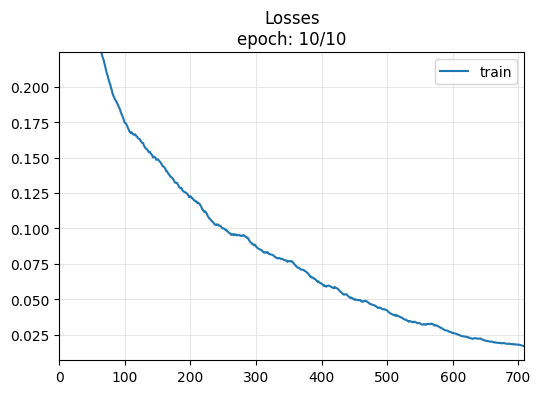

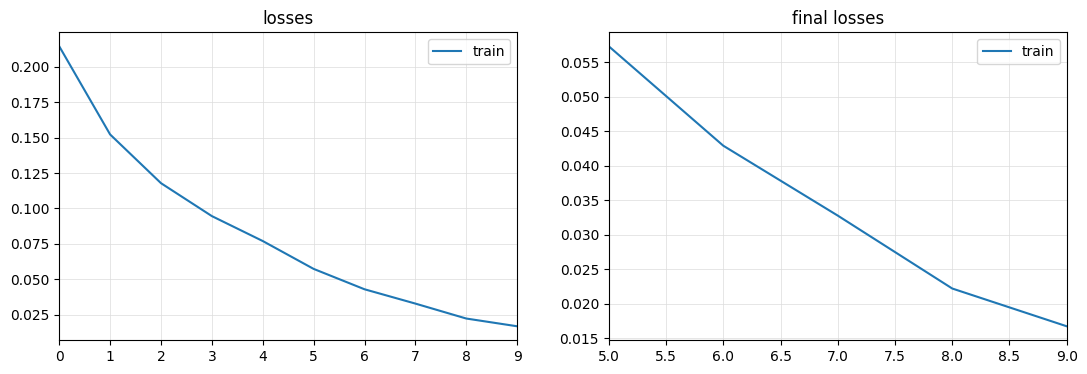

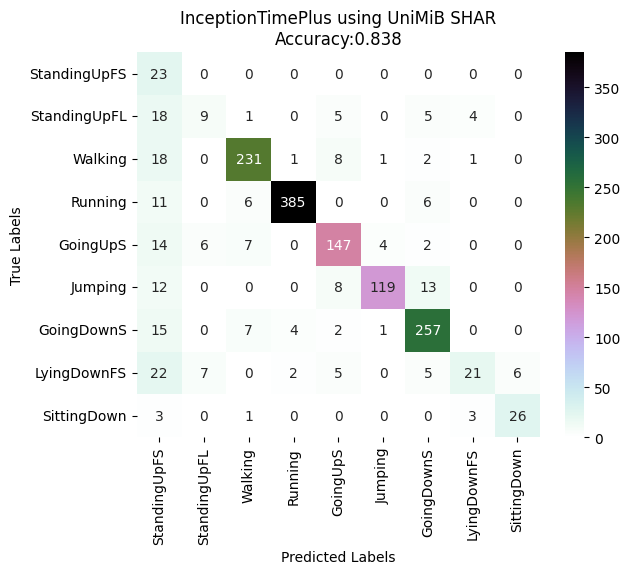

Prediction accuracy: 0.838
              precision    recall  f1-score   support

StandingUpFS       0.17      1.00      0.29        23
StandingUpFL       0.41      0.21      0.28        42
     Walking       0.91      0.88      0.90       262
     Running       0.98      0.94      0.96       408
    GoingUpS       0.84      0.82      0.83       180
     Jumping       0.95      0.78      0.86       152
  GoingDownS       0.89      0.90      0.89       286
 LyingDownFS       0.72      0.31      0.43        68
 SittingDown       0.81      0.79      0.80        33

    accuracy                           0.84      1454
   macro avg       0.74      0.74      0.69      1454
weighted avg       0.88      0.84      0.85      1454

**** Processing  UCI HAR  ****
Unzipping UCI_HAR_Dataset.zip file

The validation group is generated using sklearn stratify on train
It is not subject independent - confirm accuracy with test set
array    shape           data type
-------  --------------  -----------


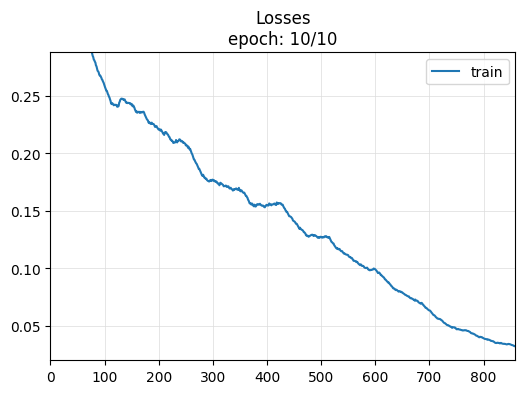

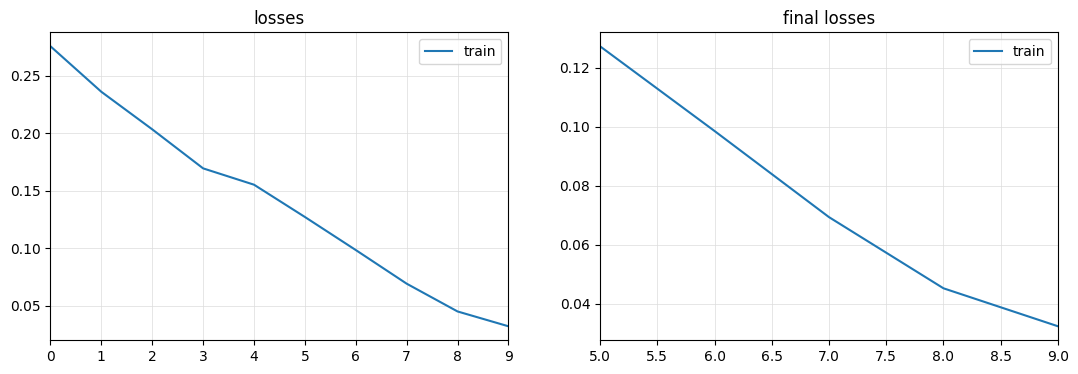

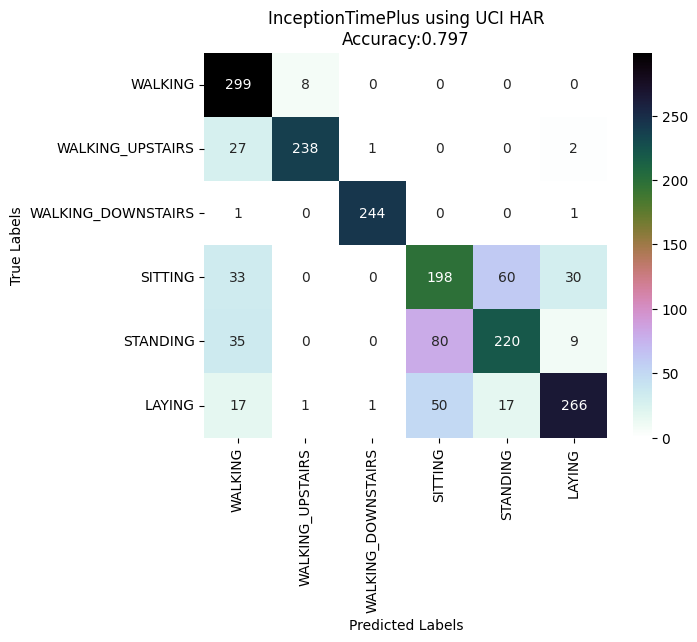

Prediction accuracy: 0.797
                    precision    recall  f1-score   support

           WALKING       0.73      0.97      0.83       307
  WALKING_UPSTAIRS       0.96      0.89      0.92       268
WALKING_DOWNSTAIRS       0.99      0.99      0.99       246
           SITTING       0.60      0.62      0.61       321
          STANDING       0.74      0.64      0.69       344
            LAYING       0.86      0.76      0.81       352

          accuracy                           0.80      1838
         macro avg       0.81      0.81      0.81      1838
      weighted avg       0.80      0.80      0.80      1838

**** Processing  TWristAR  ****
Unzipping TWristAR file in . directory
90/10 split of the training group.  It is not subject independent.
array    shape          data type
-------  -------------  -----------
x_train  (1869, 96, 1)  float32
y_train  (1869, 6)      uint8
x_valid  (208, 96, 1)   float32
y_valid  (208, 6)       uint8
x_test   (1091, 96, 1)  float32
y_test

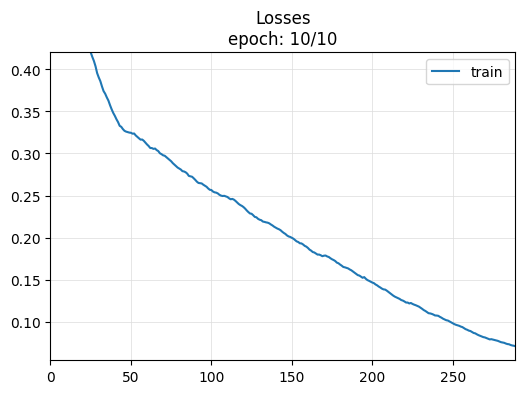

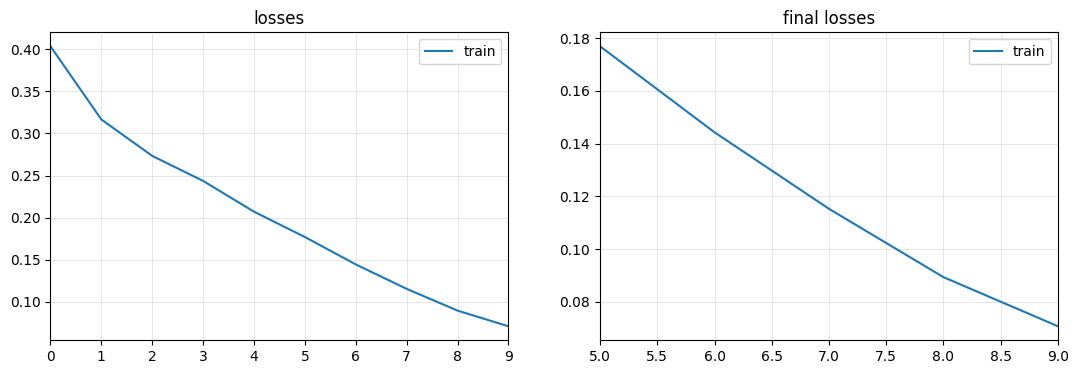

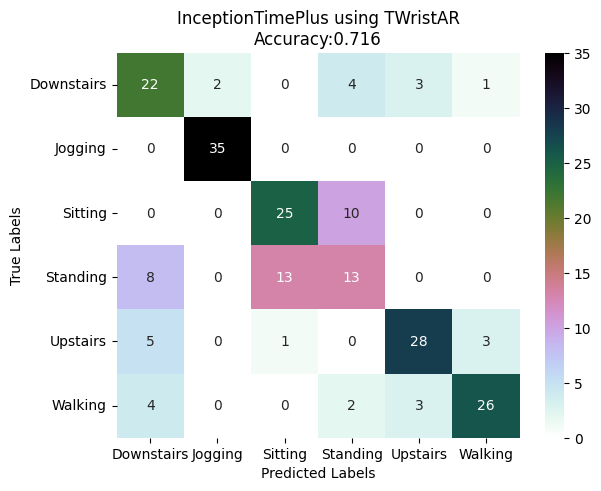

Prediction accuracy: 0.716
              precision    recall  f1-score   support

  Downstairs       0.56      0.69      0.62        32
     Jogging       0.95      1.00      0.97        35
     Sitting       0.64      0.71      0.68        35
    Standing       0.45      0.38      0.41        34
    Upstairs       0.82      0.76      0.79        37
     Walking       0.87      0.74      0.80        35

    accuracy                           0.72       208
   macro avg       0.71      0.71      0.71       208
weighted avg       0.72      0.72      0.72       208

**** Processing  Leotta_2021  ****
Unzipping Leotta 2021 dataset into ./dataset
Using source file ./ADL_Leotta_2021.zip
array    shape           data type
-------  --------------  -----------
x_train  (2391, 300, 3)  float32
y_train  (2391, 18)      uint8
x_valid  (1167, 300, 3)  float32
y_valid  (1167, 18)      uint8
x_test   (1987, 300, 3)  float32
y_test   (1987, 18)      uint8


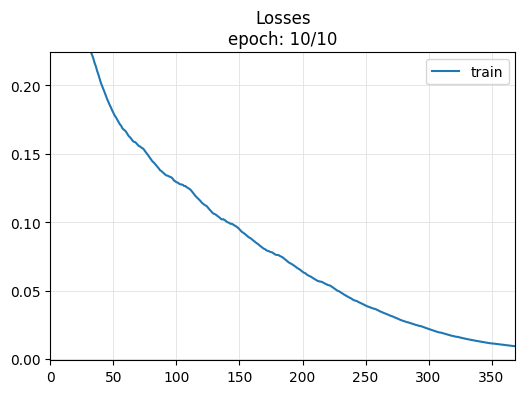

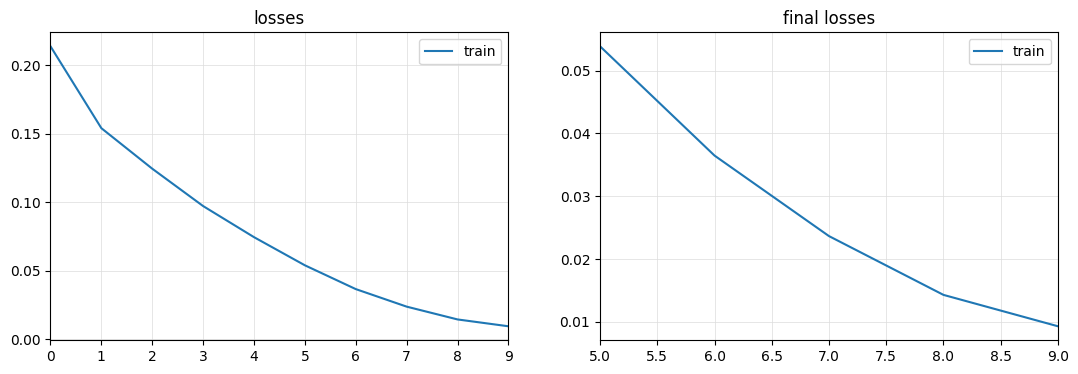

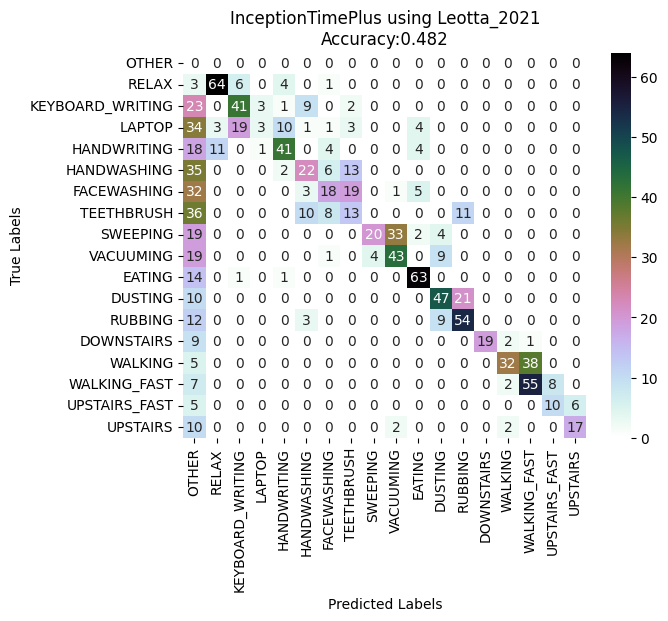

Prediction accuracy: 0.482
                  precision    recall  f1-score   support

           OTHER       0.00      0.00      0.00         0
           RELAX       0.82      0.82      0.82        78
KEYBOARD_WRITING       0.61      0.52      0.56        79
          LAPTOP       0.43      0.04      0.07        78
     HANDWRITING       0.69      0.52      0.59        79
     HANDWASHING       0.46      0.28      0.35        78
     FACEWASHING       0.46      0.23      0.31        78
      TEETHBRUSH       0.26      0.17      0.20        78
        SWEEPING       0.83      0.26      0.39        78
       VACUUMING       0.54      0.57      0.55        76
          EATING       0.81      0.80      0.80        79
         DUSTING       0.68      0.60      0.64        78
         RUBBING       0.63      0.69      0.66        78
      DOWNSTAIRS       1.00      0.61      0.76        31
         WALKING       0.84      0.43      0.57        75
    WALKING_FAST       0.59      0.76      0

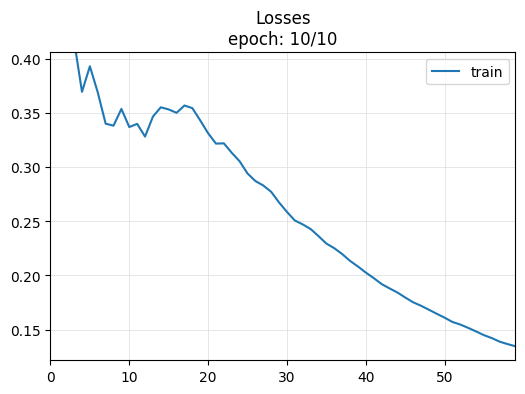

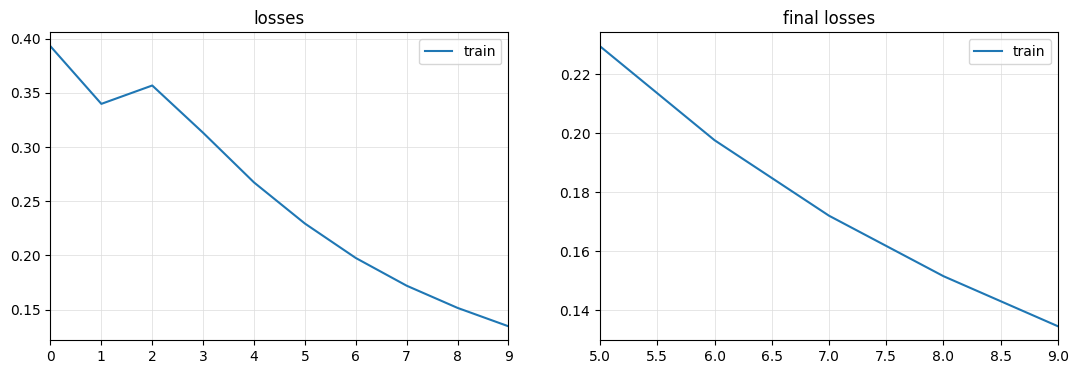

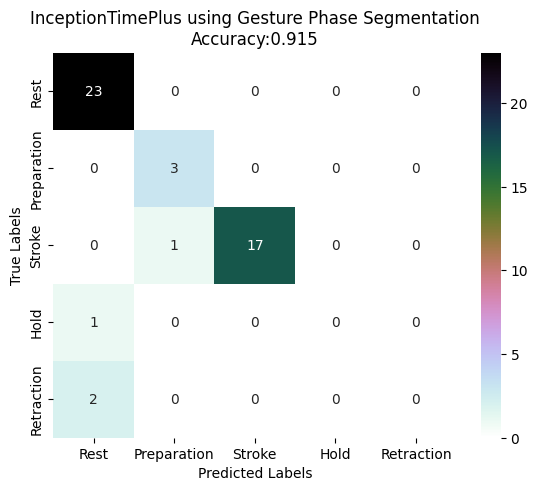

Prediction accuracy: 0.915
              precision    recall  f1-score   support

        Rest       0.88      1.00      0.94        23
 Preparation       0.75      1.00      0.86         3
      Stroke       1.00      0.94      0.97        18
        Hold       0.00      0.00      0.00         1
  Retraction       0.00      0.00      0.00         2

    accuracy                           0.91        47
   macro avg       0.53      0.59      0.55        47
weighted avg       0.86      0.91      0.89        47



In [11]:
log_out = "Running: " + str(', '.join(ds_list))
model_acc = []
for i in ds_list:
    dataset = i
    print("**** Processing ", dataset, " ****")
    x_train, y_train, x_valid, y_valid, x_test, y_test, k_size, EPOCHS, t_names = get_dataset(dataset)
    # Convert one-hot encoded target and predictions to class labels
    mv_clf = train_model(x_train, y_train, x_valid, y_valid)
    preds_labels, target_labels = run_model(x_test)

    # Compute confusion matrix
    cm = confusion_matrix(target_labels, preds_labels)
    cm_df = pd.DataFrame(cm,
                     index = t_names,
                     columns = t_names)
    fig = plt.figure(figsize=(6.5,5))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='cubehelix_r')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('InceptionTimePlus using '+dataset+'\nAccuracy:{0:.3f}'.format(accuracy_score(target_labels, preds_labels)))
    plt.show()

    # Print print prediction accuracy
    print('Prediction accuracy: {0:.3f}'.format(accuracy_score(target_labels, preds_labels)))
    # Print a report of classification performance metrics
    print(classification_report(target_labels, preds_labels, target_names=t_names))